<a href="https://www.kaggle.com/code/zukhrakhongulomova/automated-refund-item-classification-system?scriptVersionId=232297753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Automated Refund Item Classification System

## ✅ Summary

- Used a fashion product dataset with 27 classes.
- Trained a ResNet-18 classifier with ~81% validation accuracy.
- Added data augmentations and transfer learning to improve generalization.
- Evaluated model using accuracy, precision, recall, F1-score, and confusion matrix.
- Exported model for deployment in FastAPI and Docker environments.

➡️ Ready for production with nightly batch classification support!

## Links to full project
- GitHub: https://github.com/gulomovazukhrakhon/refund-classifier 
- DockerHub: https://hub.docker.com/r/zukhrakhon/refund-classifier

### Notebook Imports

In [1]:
!pip install torchview

In [2]:
import os
import json
import pathlib
import sklearn
import pandas as pd
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms
from torchview import draw_graph

from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Data Loading & Data Preprocessing

In [3]:
image_paths = Path("/kaggle/input/fashion-product-text-images-dataset/data")
image_paths_list = list(image_paths.glob('*.jpg'))

In [4]:
fashion_df = pd.read_csv("/kaggle/input/fashion-product-text-images-dataset/data.csv")
fashion_df.head()

,image,description,display name,category
0,3238.jpg,"Round toed, black sports shoes with red accent...",Puma Men Black 65CC Lo Ducati Sports Shoes,Sports Shoes
1,43044.jpg,Style Note Built with the breathability and ze...,Nike Men Charcoal Grey Shorts,Shorts
2,54018.jpg,Teal handbag that has stitch detailing with a...,Kiara Women Teal Handbag,Handbags
3,8141.jpg,"Perfectly stylish, this fastrack analog wrist ...",Fastrack Women Freestyle Sports Analog Steel B...,Watches
4,22245.jpg,These id mid-top chukka shoes add a fresh spin...,ID Men Brown Casual Shoes,Casual Shoes


In [5]:
# Filter out item_name categories with fewer than 500 images
fashion_df = fashion_df[fashion_df['category'].map(fashion_df['category'].value_counts()) >= 400]

# Keep only the first 120 images for each item_name
fashion_df = fashion_df.groupby('category').head(600)
fashion_df.shape

(15362, 4)

In [6]:
fashion_df.to_csv("data.csv")

In [7]:
train_fashion, test_fashion = train_test_split(fashion_df, shuffle=True, test_size=0.1)
train_fashion, val_fashion = train_test_split(train_fashion, shuffle=True, test_size=0.2)

print(f"Train Shape: {train_fashion.shape}, \nValidation Shape: {val_fashion.shape}, \nTest Shape: {test_fashion.shape}")

Train Shape: (11060, 4), 
Validation Shape: (2765, 4), 
Test Shape: (1537, 4)


In [8]:
output_dir = 'test_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

root = "/kaggle/input/fashion-product-text-images-dataset/data"

for index, row in test_fashion.iterrows():
    path = os.path.join(root,row['image'])
    test_path = os.path.join(output_dir, os.path.basename(path))

    try:
        shutil.copy(path, test_path)
    except Exception as e:
        print(f"Failed to copy {path}: {e}")

In [9]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

### Exploratory Data Analysis¶

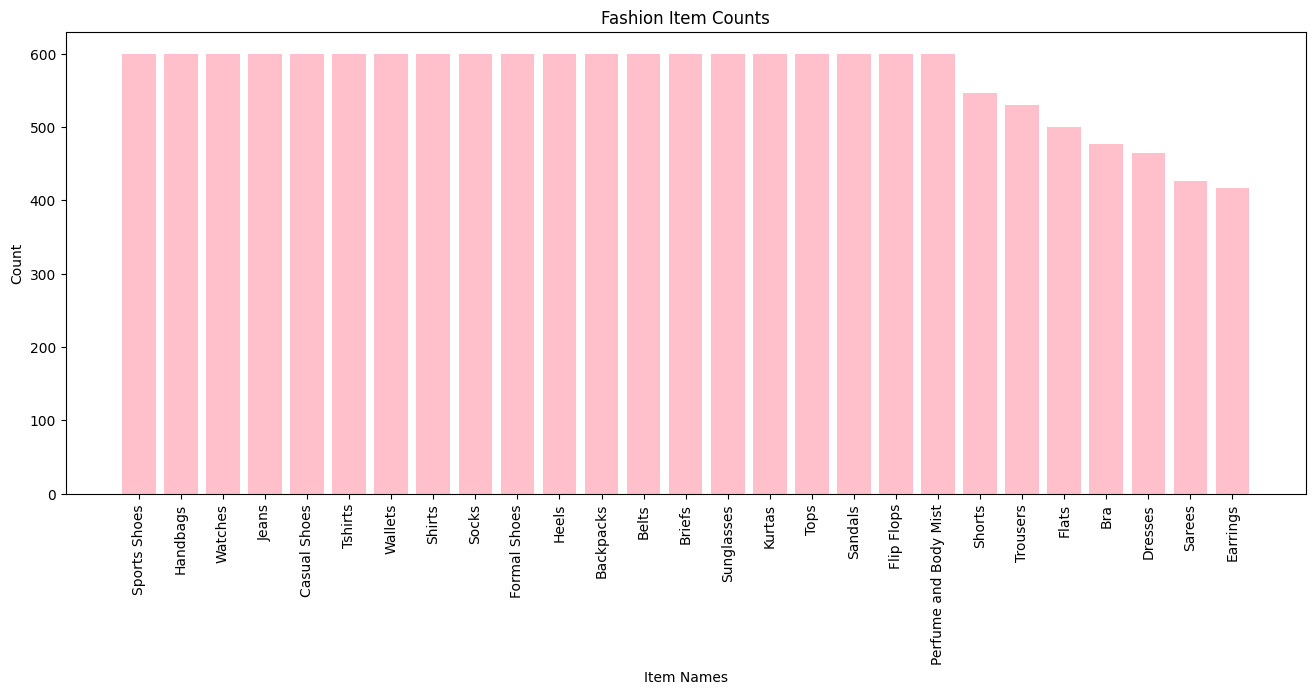

In [10]:
item_counts = fashion_df['category'].value_counts()

plt.figure(figsize=(16, 6))
plt.bar(item_counts.index, item_counts, color='pink')
plt.title("Fashion Item Counts")
plt.xlabel('Item Names')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

### Data Transformation

In [11]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
classes = fashion_df['category'].unique()
classes_idx = {label:i for i, label in enumerate(classes)}

In [13]:
classes

array(['Sports Shoes', 'Shorts', 'Handbags', 'Watches', 'Casual Shoes',
       'Tshirts', 'Wallets', 'Jeans', 'Socks', 'Dresses', 'Shirts',
       'Heels', 'Earrings', 'Formal Shoes', 'Briefs', 'Sunglasses',
       'Sarees', 'Kurtas', 'Trousers', 'Flip Flops', 'Sandals', 'Tops',
       'Perfume and Body Mist', 'Backpacks', 'Belts', 'Bra', 'Flats'],
      dtype=object)

In [14]:
with open("classes.json", "w") as outfile: 
    json.dump(classes_idx, outfile)

In [15]:
class CaltechDataset(Dataset):
    def __init__(self, dataframe, idx, root, transform=None):
        self.df = dataframe
        self.class_idx = idx
        self.transform = transform
        self.root = root
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(root, row['image'])
        image = Image.open(path).convert('RGB')
        label = self.class_idx[row['category']]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [16]:
# Train Set
train_dataset = CaltechDataset(dataframe=train_fashion, idx=classes_idx, transform=train_transform, root=root)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())

# Validation Set
val_dataset = CaltechDataset(dataframe=val_fashion, idx=classes_idx, transform=val_transform, root=root)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())

# Test Set
test_dataset = CaltechDataset(dataframe=test_fashion, idx=classes_idx, transform=val_transform, root=root)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())

In [17]:
train_images, train_labels = next(iter(train_dataloader))
train_images.shape, train_labels.shape, train_labels

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor([23,  1, 15,  9, 19, 26, 15, 20,  5, 16, 15, 15,  1, 25, 21,  4, 25, 20,
         23,  3,  3,  4, 24,  3, 13,  6, 20, 17, 26, 13,  2, 25]))

In [18]:
# Visualizing images with their corresponding labels

def visualize_batch(images, labels):
    rows, cols = 8, 4 
    fig, axes = plt.subplots(rows, cols, figsize=(16, 24))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            ax.axis('off')
            continue

        image = images[i]
        ax.imshow(image.permute(1,2,0))
        ax.set_title(f"Item Id: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

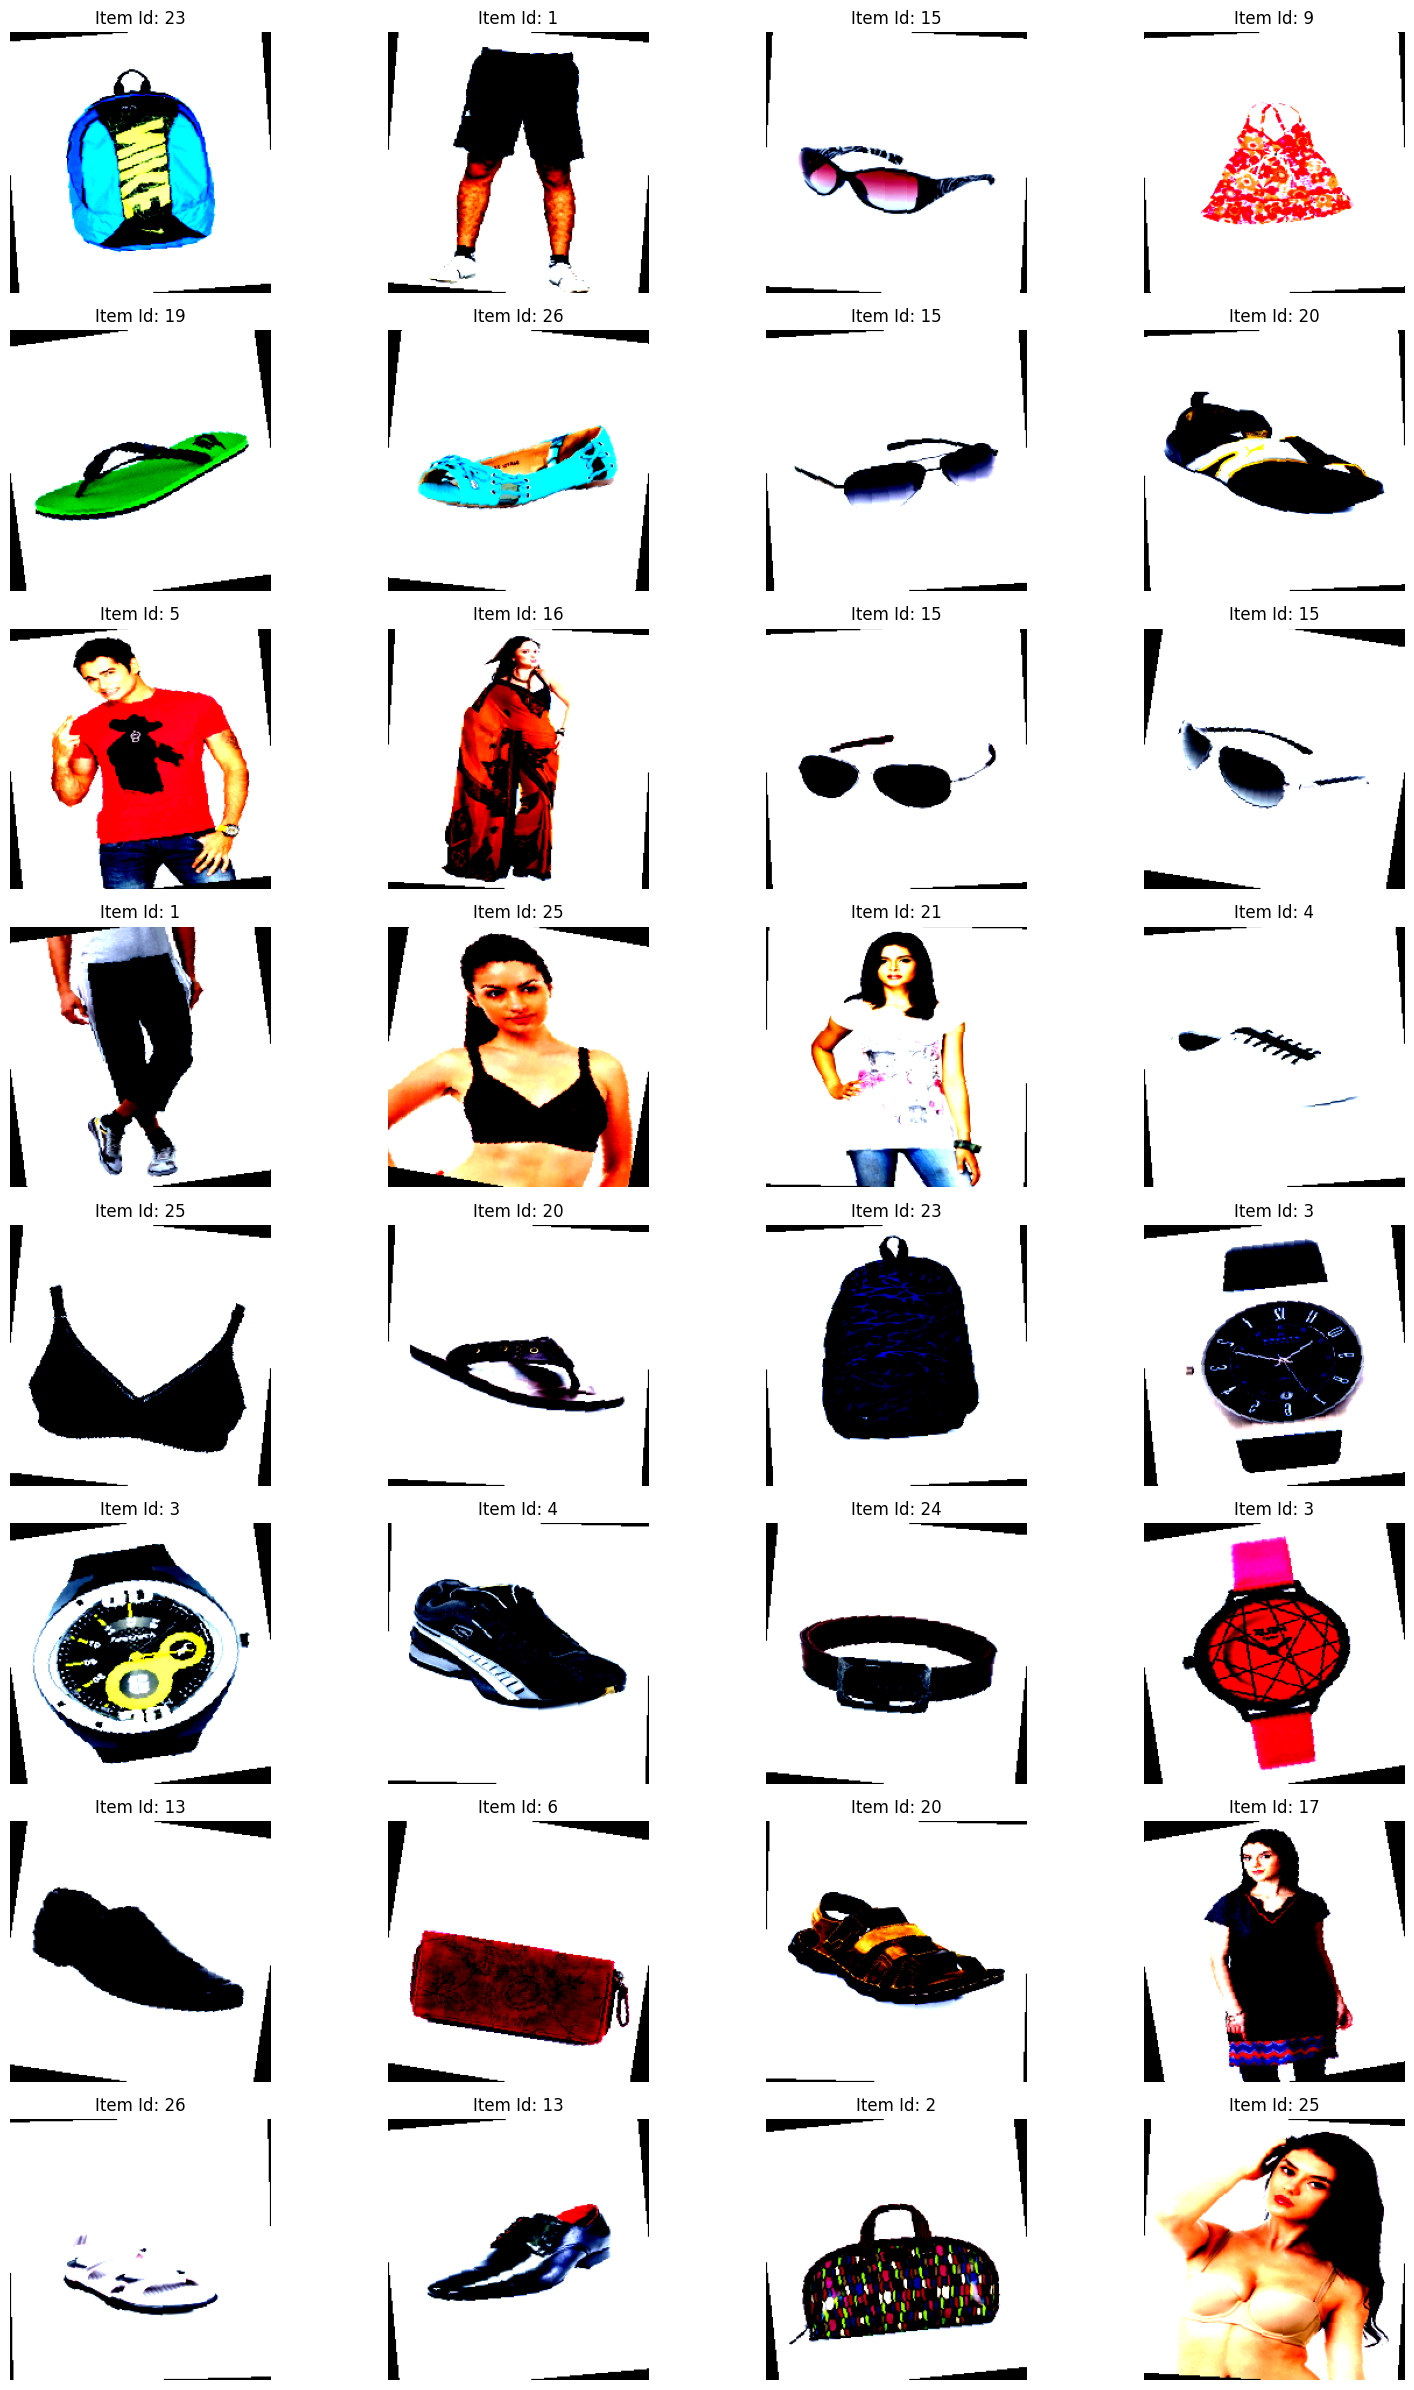

In [19]:
visualize_batch(train_images, train_labels)

### Model Architecture

In [20]:
class CustomModel(nn.Module):
    def __init__(self, caltech_len:int, hidden_units: int) -> None:
        super().__init__()

        resnet = models.resnet18(pretrained=True)
        self.resnet_layers = nn.Sequential(*list(resnet.children())[:-1])
        
        self.classifier = nn.Sequential(
            nn.Linear(512, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, caltech_len)
        )

    def forward(self, x):
        features = self.resnet_layers(x)
        features = torch.flatten(features, 1)
        logits = self.classifier(features)

        return logits

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [22]:
model = CustomModel(caltech_len=len(classes), hidden_units=128).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [23]:
dummy_input = torch.rand(1, 3, 224, 224).to(device)
dummpy_output = model(dummy_input)
dummpy_output.shape

torch.Size([1, 27])

In [24]:
summary(model, input_size=dummy_input.shape)

Layer (type:depth-idx)                        Output Shape              Param #
CustomModel                                   [1, 27]                   --
├─Sequential: 1-1                             [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]          295,42

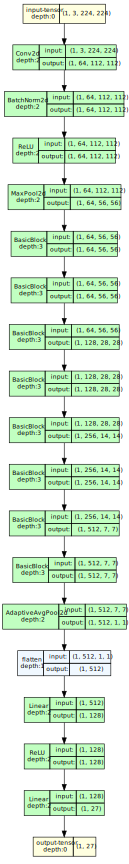

In [25]:
model_graph = draw_graph(model, input_size=dummy_input.shape, 
                         device=device, roll=True, save_graph=True)
model_graph.visual_graph

### Model Training

In [26]:
def train_step(model, dataloader, loss_fn, optimizer, device=device):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward Pass
        logits = model(X)
        

        # Calculate the Loss
        loss = loss_fn(logits, y)
        train_loss += loss.item()

        # Optimizer Zero Grad
        optimizer.zero_grad()

        # Loss Backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

        # Calculate Accuracy Metric
        y_pred_class = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(logits)

    # Average Loss and Accuracy
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [27]:
def test_step(model, dataloader, loss_fn, device=device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the Loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate the Accuracy
            test_pred_class = test_pred.argmax(dim=1)
            test_acc += ((test_pred_class==y).sum().item() / len(test_pred_class))

        # Average Loss and Accuracy
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

In [28]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs:int=5, device=device):
    results = {
        'train_loss': [], 
        'train_acc': [], 
        'test_loss': [], 
        'test_acc': []
    }

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, dataloader=train_dataloader, loss_fn=loss_fn, 
                                           optimizer=optimizer, device=device)

        test_loss, test_acc = test_step(model, dataloader=test_dataloader, 
                                        loss_fn=loss_fn, device=device)

        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc: .4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [29]:
start_time = timer()
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
model_results = train(model=model, train_dataloader=train_dataloader, 
                      test_dataloader=val_dataloader, optimizer=optimizer, 
                      loss_fn=loss_fn, epochs=5)

end_time =timer()
print(f'Total Training Time: {end_time-start_time: 3f} seconds')

Epoch: 0 | Train Loss: 0.8054 | Train Acc:  0.7983 | Test Loss: 0.3017 | Test Acc: 0.8917
Epoch: 1 | Train Loss: 0.2750 | Train Acc:  0.9078 | Test Loss: 0.2242 | Test Acc: 0.9181
Epoch: 2 | Train Loss: 0.2079 | Train Acc:  0.9266 | Test Loss: 0.2142 | Test Acc: 0.9239
Epoch: 3 | Train Loss: 0.1685 | Train Acc:  0.9408 | Test Loss: 0.2153 | Test Acc: 0.9194
Epoch: 4 | Train Loss: 0.1430 | Train Acc:  0.9509 | Test Loss: 0.2147 | Test Acc: 0.9235
Total Training Time:  551.625422 seconds


### Model Evaluation

In [30]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary"""
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_acc')
    plt.plot(epochs, test_accuracy, label='test_acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.savefig("model_results.png")
    plt.legend()

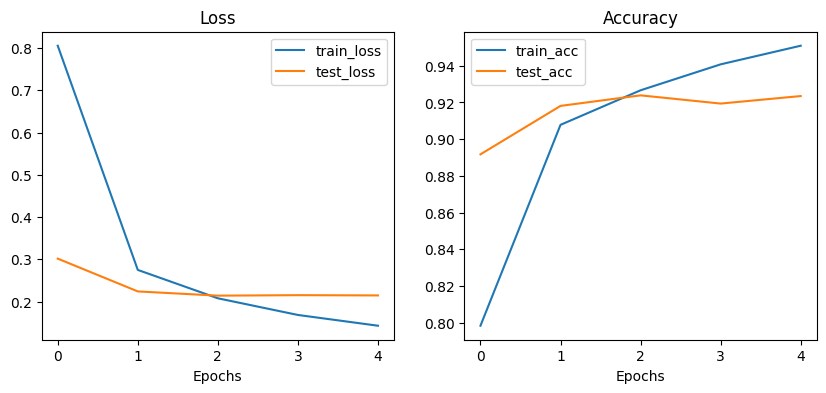

In [31]:
plot_loss_curves(model_results)

In [32]:
y_true, y_pred = [], []

with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)
        test_pred = model(X)
        test_pred_class = test_pred.argmax(dim=1)

        # Convert each label and prediction to scalar integers
        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(test_pred_class.cpu().numpy().tolist())

In [33]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=classes))

                       precision    recall  f1-score   support

         Sports Shoes       0.81      0.93      0.87        71
               Shorts       0.98      0.98      0.98        55
             Handbags       0.97      0.95      0.96        62
              Watches       1.00      1.00      1.00        70
         Casual Shoes       0.83      0.72      0.77        54
              Tshirts       0.90      0.90      0.90        49
              Wallets       0.95      1.00      0.97        52
                Jeans       0.96      0.96      0.96        57
                Socks       1.00      1.00      1.00        52
              Dresses       0.91      0.85      0.88        34
               Shirts       1.00      0.97      0.99        71
                Heels       0.83      0.55      0.66        55
             Earrings       1.00      1.00      1.00        33
         Formal Shoes       0.98      1.00      0.99        47
               Briefs       1.00      1.00      1.00  

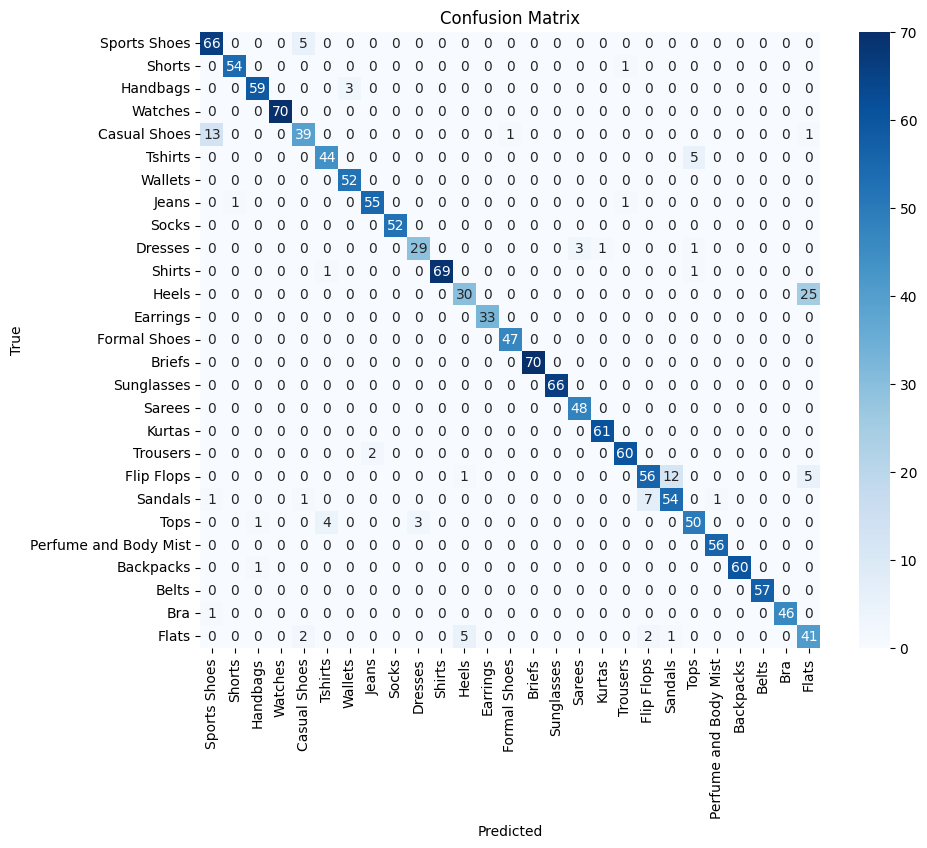

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Model Testing on Real Images

In [35]:
def predict_on_images(model, image_path, classes, transform=None, device=device):
    image = torchvision.io.read_image(image_path).type(torch.float32) / 255

    if transform:
        image = transform(image)

    model.to(device)
    model.eval()

    with torch.no_grad():
        image = image.unsqueeze(0)
        results = model(image.to(device))

    y_probs = torch.softmax(results, dim=1)
    y_pred = torch.argmax(y_probs, dim=1)
    y_class = classes[y_pred]

    predictions = {
        'Image': image,
        'Class Prediction': y_class,
        'Probability': y_probs.max()
    }
    return predictions

In [36]:
base_root = "/kaggle/working/test_images/"
image_path = os.path.join(base_root, test_fashion['image'].iloc[3])

predict_on_images(model=model, classes=classes, transform=test_transform, device=device, image_path=image_path)

{'Image': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           ...,
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
          [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           ...,
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
          [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.6

In [37]:
def visualize_predictions(model, image_path, classes, transform=None, device=device):
    predictions = predict_on_images(model=model, classes=classes, transform=test_transform, device=device, image_path=image_path)
    plt.imshow(predictions['Image'].squeeze().permute(1, 2, 0))
    title = f"Class Prediction: {predictions['Class Prediction']} \nProbability: {predictions['Probability']:.3f}"
    plt.title(title)
    plt.axis(False)

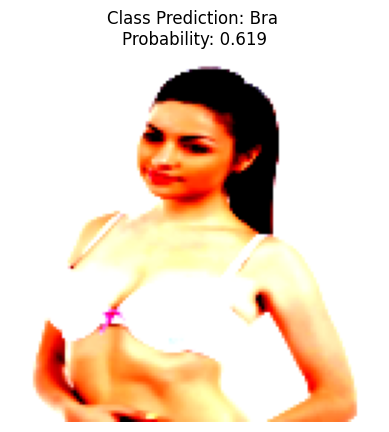

In [38]:
visualize_predictions(model=model, classes=classes, transform=test_transform, device=device, image_path=image_path)

In [39]:
def batch_predict(saved_model, image_dir, output_file, classes, device=device):
    results = []
    for image_filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        input_tensor = val_transform(image).unsqueeze(0).to(device) # Batch Dimension
        with torch.no_grad():
            saved_model.to(device)
            output = saved_model(input_tensor)
            predicted_class = classes[torch.argmax(output, dim=1).item()]
            class_probability = torch.softmax(output, dim=1).max()
            
        results.append({
            "image": image_filename, 
            "class": predicted_class,
            "probability": round(float(class_probability), 2)
        })

    pd.DataFrame(results).to_csv(output_file, index=False)

In [40]:
batch_predict(model, "test_images/", "predictions_with_classes.csv", classes)

## Save a Model

In [41]:
!zip -r file /kaggle/working/data

	zip warning: name not matched: /kaggle/working/data

zip error: Nothing to do! (try: zip -r file . -i /kaggle/working/data)


In [42]:
!ls

classes.json  model.gv	    model_results.png	predictions_with_classes.csv
data.csv      model.gv.png  __notebook__.ipynb	test_images


In [43]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [44]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt')